# 루브릭
1. 이미지 분류기 모델이 성공적으로 만들어졌는가?
    - 학습 과정이 정상적으로 수행되었으며, 학습 결과에 따른 시각화(ex. train acc, val acc, train loss, val loss 등) 해 보았음.
2. 오버피팅을 극복하기 위한 적절한 시도가 있었는가?
    - 오버피팅 극복을 위하여 데이터셋의 다양성, 정규화 등 2가지 이상 시도해보았음.
3. 분류모델의 test accuracy가 기준 이상 높게 나왔는가?
    - 60% 이상 도달하였음.

### 필요한 라이브러리 불러오기

In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt

### 필요한 함수 생성하기

In [2]:
def resize_images(img_path):
    images=glob.glob(img_path + "/*.jpg")  
    
    print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
    target_size=(28,28)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
    
    print(len(images), " images resized.")

train과 test data의 이미지가 300x300에 해상도를 가지고 있어 학습을 하게 되면, 높은 결과를 보여주어 CNN 공부를 하는데 있어, 효과가 없었다.
따라서, 이를 28x28로 resize를 해주어 학습 실험을 진행하였다.

In [3]:
def load_data(img_path, number_of_data=840*3):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("이미지 개수는", idx,"입니다.")
    return imgs, labels

In [4]:
# 고해상도 이미지에는 성능이 좋게 나오기 때문에 해상도를 낮추어 여러 실험을 진행하며 하이퍼파라미터 수정을 하자.

# 이미지 resize
image_dir_path = "data/train/scissors"
# 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
resize_images(image_dir_path)

840  images to be resized.


C:\Users\tkdgu\AppData\Local\Temp\ipykernel_18416\3840000890.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  new_img=old_img.resize(target_size,Image.ANTIALIAS)


840  images resized.


In [5]:
(x_train, y_train)=load_data('data/train')

이미지 개수는 1680 입니다.


In [6]:
x_train_norm = x_train/255.0

학습의 효과를 높여주기 위해 normalize(정규화)를 진행하였다. 이로 인해 학습 overfitting을 방지할 수 있다.

In [7]:
x_train_norm.shape

(2520, 28, 28, 3)

라벨:  1


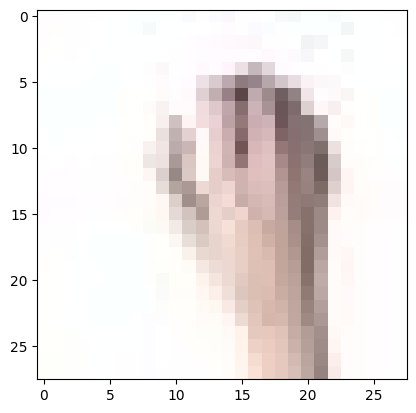

In [8]:
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

### 모델 생성

In [9]:
import tensorflow as tf
from tensorflow import keras


model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (5,5), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation='relu')) #10, 50, 100으로 실험 진행 100:overfitting 발생
model.add(keras.layers.Dropout(0.5)) #0.2, 0.5, 0.8 로 실험을 진행행
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 32)          12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 10)                5

우선 간단한 CNN 모델을 만들어보았다. 여러 층이 쌓여 있지만 내가 실험한 부분에 Dense layer와 Dropout 이다. Dense Layer 층을 10, 50, 100으로 실험을 진행해보았는데, 50과 100은 Overfitting이 발생하였고, Dropout은 0.5의 값이 적절한 결과를 보여주었다. Dropout Layer를 주석처리 했을 땐 Overfitting이 일어나 학습이 되지 않았다.

In [10]:
x_train_reshaped=x_train_norm.reshape( -1, 28, 28, 3)

In [11]:
x_train_reshaped.shape

(2520, 28, 28, 3)

In [12]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(x_train_reshaped, y_train, epochs=100)

Epoch 1/100
79/79 [==============================] - 1s 13ms/step - loss: 0.8517 - accuracy: 0.6016
Epoch 2/100
79/79 [==============================] - 1s 12ms/step - loss: 0.4760 - accuracy: 0.7306
Epoch 3/100
79/79 [==============================] - 0s 5ms/step - loss: 0.3496 - accuracy: 0.8357
Epoch 4/100
79/79 [==============================] - 1s 9ms/step - loss: 0.3059 - accuracy: 0.8675
Epoch 5/100
79/79 [==============================] - 1s 12ms/step - loss: 0.2745 - accuracy: 0.8758
Epoch 6/100
79/79 [==============================] - 1s 9ms/step - loss: 0.2269 - accuracy: 0.8861
Epoch 7/100
79/79 [==============================] - 0s 6ms/step - loss: 0.1989 - accuracy: 0.8853
Epoch 8/100
79/79 [==============================] - 1s 8ms/step - loss: 0.1851 - accuracy: 0.8960
Epoch 9/100
79/79 [==============================] - 1s 8ms/step - loss: 0.1738 - accuracy: 0.9179
Epoch 10/100
79/79 [==============================] - 1s 8ms/step - loss: 0.1871 - accuracy: 0.9250
Epoch 

In [13]:
history.history

{'loss': [0.8517175912857056,
  0.475994735956192,
  0.3495890200138092,
  0.3059043884277344,
  0.27450767159461975,
  0.22692875564098358,
  0.1989433616399765,
  0.18513834476470947,
  0.17380863428115845,
  0.18707171082496643,
  0.15824854373931885,
  0.1446254402399063,
  0.16004565358161926,
  0.14461712539196014,
  0.13222810626029968,
  0.14527365565299988,
  0.13416334986686707,
  0.14172978699207306,
  0.13558469712734222,
  0.13111793994903564,
  0.12887915968894958,
  0.1323409527540207,
  0.13990099728107452,
  0.1378536820411682,
  0.14549200236797333,
  0.13992498815059662,
  0.12340153008699417,
  0.11832091212272644,
  0.13375650346279144,
  0.1267234981060028,
  0.1214752197265625,
  0.12032653391361237,
  0.1280367374420166,
  0.11670016497373581,
  0.11169909685850143,
  0.13609889149665833,
  0.13140828907489777,
  0.13332301378250122,
  0.12829993665218353,
  0.13488410413265228,
  0.1311541199684143,
  0.12132280319929123,
  0.11478737741708755,
  0.121553547680

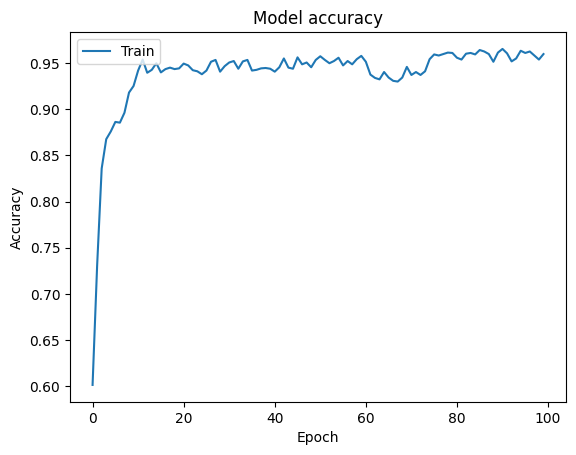

In [14]:
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train'], loc='upper left')
plt.show()

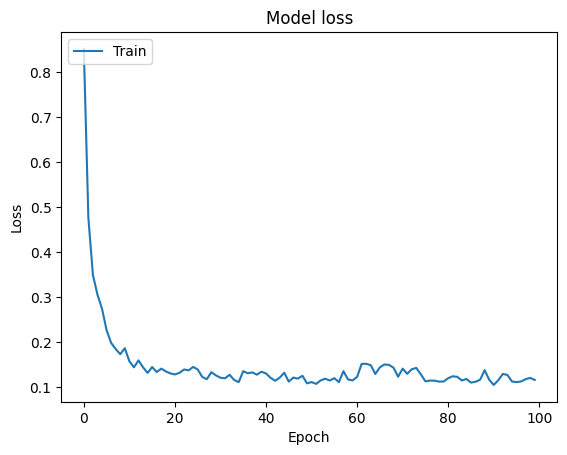

In [15]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train'], loc='upper left')
plt.show()

ACC, Loss 그래프에서 볼 수 있듯이 학습이 잘 되었고, Dropout/Normalize 등 기법들을 사용하여 Overfitting이 방지되었다.

In [16]:
(x_test, y_test)=load_data('data/test')

x_test_norm = x_test/255.0

이미지 개수는 266 입니다.


In [17]:
x_test_reshaped=x_test_norm.reshape( -1, 28, 28, 3)

In [18]:
test_loss, test_accuracy = model.evaluate(x_test_reshaped,y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

79/79 - 0s - loss: 0.2095 - accuracy: 0.9841 - 396ms/epoch - 5ms/step
test_loss: 0.20952260494232178
test_accuracy: 0.9841269850730896


우선 학습 결과를 그래프로 확인하였을 때 좋은 결과를 얻을 수 있었으며, Overfitting, 정규화, 그리고 처음 데이터양인 300장에서 약 2000장가량 늘려 학습을 했기때문에 Overfitting을 방지할 수 있었다. Overfitting은 딥러닝에서 잘 일어나는 것으로 여러가지로 해결을 하고있다. 추가적으로, 이후 ResNet에서도 Overfitting을 방지하는 기법이 하나가 소개가 된다.

이 프로젝트를 통해 간단하지만 Overfitting의 해결법들을 알아볼 수 있었고 여러 실험을 통해 각 Layer들에 값이 변화할 때 어떻게 변하게 되는지 수치로 확인할 수 있었다.